In [1]:
library(cli)
library(karyoploteR)
library(tidyverse)
library(GenomicRanges)
library(regioneR)
library(readxl)

Loading required package: regioneR

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading

In [2]:
setwd('../../data/MAT')

In [3]:
read_gff <- function(file) {
  gff <- read.table(file, sep = '\t', header = FALSE)
  colnames(gff) <- c('seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute')
  gff <-gff %>%mutate(attribute = gsub('-T.*', '', attribute))%>%mutate(attribute = gsub('ID=', '', attribute))%>%mutate(attribute = gsub(';', '', attribute))
  return(gff)
}

In [4]:
hapA.gff <-read_gff('20240815_Au3_deduplicate_hapA.gff3')%>%mutate(seqname = gsub('AU3_HapA_CHR', 'Chr', seqname))
hapA.gff$seqname <- paste0(as.character(hapA.gff$seqname) , "A")
hapB.gff <-read_gff('20240815_Au3_deduplicate_hapB.gff3')%>%mutate(seqname = gsub('AU3_HapB_CHR', 'Chr', seqname))
hapB.gff$seqname <- paste0(as.character(hapB.gff$seqname) , "B")
gff <- rbind(hapA.gff, hapB.gff)

In [5]:
TE<-read_table('Au3.TE.bed', col_names = FALSE)
colnames(TE)<-c('seqname', 'start', 'end')


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double()
)



In [6]:
#Now convert the yn00 output to suitable format
yn00_table <-read_table('Au3.dN.dS.out', col_names = FALSE)
yn00_table <-yn00_table %>%select(X1,X2,X8,X10)
colnames(yn00_table) <-c('gene1','gene2','dN','dS')
yn00_table <-yn00_table %>%mutate(gene1 = gsub('-T.*', '', gene1))%>%mutate(gene2 = gsub('-T.*', '', gene2))


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double()
)



In [7]:
yn00_table.gff <-yn00_table %>%left_join(hapA.gff, by = c('gene2' = 'attribute'))%>%left_join(hapB.gff, by = c('gene1' = 'attribute'))
yn00_table.gff<-yn00_table.gff %>%select(seqname.x, start.x, end.x, seqname.y, start.y, end.y, dN, dS)
colnames(yn00_table.gff) <-c('seqname1', 'start1', 'end1', 'seqname2', 'start2', 'end2', 'dN', 'dS')

In [11]:
cen<-read_table('../20250220_cen.table', col_names = FALSE)
colnames(cen) <-c('seqname', 'start', 'end')


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double()
)



In [13]:
MAT.gene <-read_table('MAT.list', col_names = FALSE)
colnames(MAT.gene) <-c('gene_type', 'gene')


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_character()
)



In [14]:
genome<-read_table('Au3.genome', col_names = FALSE)
genome$start <-1
genome<-genome %>%select(X1, start, X2)
colnames(genome) <-c('seqname', 'start', 'end')



── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double()
)



In [15]:
calculate_cov<-function(genome, window_size, gff, chr){
    query<-gff%>%select(c(seqname, start, end))%>%filter(seqname == as.character(chr))
    query <-query%>%as.data.frame()%>%toGRanges()
    genome <-genome%>%as.data.frame() %>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))%>%filter(seqname == as.character(chr))
    colnames(genome) <-c('seqname', 'start','end')
    windows<-tileGenome(setNames(as.vector(genome$end), genome$seqname), tilewidth = window_size, cut.last.tile.in.chrom = TRUE)
    overlaps <- findOverlaps(windows, query)
    overlap_widths <- width(pintersect(windows[queryHits(overlaps)], query[subjectHits(overlaps)]))
    coverage_sum <- tapply(overlap_widths, queryHits(overlaps), sum)
    result <- data.frame(
        chrom = seqnames(windows),
        start = start(windows),
        end = end(windows),
        coverage = 0,
        coverage_percent = 0
    )
    result$coverage[as.numeric(names(coverage_sum))] <- coverage_sum
    result$coverage_percent <- (result$coverage / window_size) 
    return(result)
}

In [16]:
#Read mfa file
CHR5A_mfa <-read_table('CHR5A_mfa.bed', col_names = TRUE)%>%rename(seqname=chrom)%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
CHR5B_mfa<-read_table('CHR5B_mfa.bed', col_names = TRUE)%>%rename(seqname=chrom)%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
#Assign colors based on mfa type
CHR5A_mfa$color <- '#0571B0'
CHR5B_mfa$color <-0
for (i in 1:nrow(CHR5B_mfa)) {
    if (CHR5B_mfa$name[i] == 'mfa1') {
        CHR5B_mfa$color[i] <- '#018571'
    } else if (CHR5B_mfa$name[i] == 'mfa2') {
        CHR5B_mfa$color[i] <- '#0571B0'
    } else {
        CHR5B_mfa$color[i] <- '#E66101'
    }
}
#Drop if name is mfa1
CHR5B_mfa <-CHR5B_mfa %>%filter(name != 'mfa1')
CHR5A_mfa <- CHR5A_mfa %>%as.data.frame#%>%toGRanges()
CHR5B_mfa <- CHR5B_mfa %>%as.data.frame#%>%toGRanges()


── Column specification ────────────────────────────────────────────────────────
cols(
  chrom = col_character(),
  start = col_double(),
  end = col_double(),
  strand = col_character(),
  name = col_character()
)


── Column specification ────────────────────────────────────────────────────────
cols(
  chrom = col_character(),
  start = col_double(),
  end = col_double(),
  strand = col_character(),
  name = col_character()
)



In [17]:

mfa_bed<-read_table('20241217_mfa.bed', col_names = FALSE)
colnames(mfa_bed) <-c('chrom', 'start', 'end', 'name')
for (i in 1:nrow(mfa_bed)) {
    if (mfa_bed$name[i] == 'mfa1') {
        mfa_bed$color[i] <- '#018571'
    } else if (mfa_bed$name[i] == 'mfa2') {
       mfa_bed$color[i] <- '#0571B0'
    } else {
        mfa_bed$color[i] <- '#E66101'
    }
}
#Rename the chromosome names, if contains 'HapA' then add 'A' to the end, if contains 'HapB' then add 'B' to the end
mfa_hapA <-mfa_bed %>%filter(grepl('HapA', chrom))%>%mutate(chrom = gsub('APSI_.*.CHR', 'Chr', chrom))%>%mutate(chrom = paste0(as.character(chrom), 'A'))
mfa_hapB <-mfa_bed %>%filter(grepl('HapB', chrom))%>%mutate(chrom = gsub('APSI_.*.CHR', 'Chr', chrom))%>%mutate(chrom = paste0(as.character(chrom), 'B'))
mfa_bed <-rbind(mfa_hapA, mfa_hapB)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character()
)

Warning message:
"Unknown or uninitialised column: `color`."


In [18]:
bed_5mCpG<-read_table('../Methylation/Au3_5mCpG_filtered.bed', col_names = FALSE)%>%select(c("X1", "X2","X3"))
colnames(bed_5mCpG) <-c('seqname', 'start', 'end')


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double()
)



In [19]:
bed_6mA<-read_table('../Methylation/Au3_6mA_forward.bed', col_names = FALSE)%>%select(c("X1", "X2","X3"))
colnames(bed_6mA) <-c('seqname', 'start', 'end')


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_double()
)



In [20]:
CpG_bed<-read_table('../Methylation/merge_CpG.bed')
colnames(CpG_bed) <-c('seqname', 'start', 'end')
CpG_bed <-CpG_bed %>%mutate(end = start+1)


── Column specification ────────────────────────────────────────────────────────
cols(
  Chr01A = col_character(),
  `10700` = col_double(),
  `10702` = col_double()
)



In [21]:
#write a function to calculate the proportion of 5mCpG in each window
cov_5mCpG<- function(genome, window_size, chr, CpG_bed, bed_5mCpG){
    genome_tmp <-genome%>%as.data.frame() %>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))%>%filter(seqname == as.character(chr))
    windows<-tileGenome(setNames(as.vector(genome_tmp$end), genome_tmp$seqname), tilewidth = window_size, cut.last.tile.in.chrom = TRUE)
    CpG_site <- CpG_bed%>%filter(seqname == as.character(chr))%>%as.data.frame()%>%toGRanges()
    mCpG_site <- bed_5mCpG%>%filter(seqname == as.character(chr))%>%as.data.frame()%>%toGRanges()
    CpG_site_overlaps <- findOverlaps(windows, CpG_site)
    CpG_site_overlap_widths <- width(pintersect(windows[queryHits(CpG_site_overlaps)], CpG_site[subjectHits(CpG_site_overlaps)]))
    CpG_site_coverage_sum <- tapply(CpG_site_overlap_widths, queryHits(CpG_site_overlaps), sum)
    mCpG_site_overlaps <- findOverlaps(windows, mCpG_site)
    mCpG_site_overlap_widths <- width(pintersect(windows[queryHits(mCpG_site_overlaps)], mCpG_site[subjectHits(mCpG_site_overlaps)]))
    mCpG_site_coverage_sum <- tapply(mCpG_site_overlap_widths, queryHits(mCpG_site_overlaps), sum)
    result <- data.frame(
        chrom = seqnames(windows),
        start = start(windows),
        end = end(windows),
        CpG_coverage = 0,
        m_per_CpG = 0,
        mCpG_coverage = 0
    )
    #Use overlap CpG/mCpG to calculate the coverage
    result$CpG_coverage[as.numeric(names(CpG_site_coverage_sum))] <- CpG_site_coverage_sum
    result$mCpG_coverage[as.numeric(names(mCpG_site_coverage_sum))] <- mCpG_site_coverage_sum
    result$m_per_CpG <- ifelse(result$CpG_coverage > 0, result$mCpG_coverage / result$CpG_coverage, 0)
    return(result)
}

In [22]:
#First plot HDs
HD_gene <-MAT.gene%>%filter(grepl('HD', gene_type, ignore.case = FALSE, perl = FALSE, fixed = TRUE))%>%mutate(gene = as.character(gene))
HD_gene.gff <-gff%>%mutate(attribute = as.character(attribute))%>%filter(attribute %in% HD_gene$gene)
HD_gene.gff<- HD_gene.gff %>%left_join(HD_gene, by = c('attribute' = 'gene'))
HD_genome <-genome%>%filter(seqname %in% HD_gene.gff$seqname)%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
HD_cen <-cen%>%filter(seqname %in% HD_gene.gff$seqname)%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
HD_dS<-yn00_table.gff%>%filter(seqname1 %in% HD_gene.gff$seqname)%>%filter(seqname2 %in% HD_gene.gff$seqname)
HDgene<-MAT.gene%>%filter(grepl('STE', gene_type, ignore.case = FALSE, perl = FALSE, fixed = TRUE))%>%mutate(gene = as.character(gene))
HDgene.gff <-gff%>%mutate(attribute = as.character(attribute))%>%filter(attribute %in% HDgene$gene)
HDgene.gff<- HDgene.gff %>%left_join(HDgene, by = c('attribute' = 'gene'))
PR_gene<-MAT.gene%>%filter(grepl('STE', gene_type, ignore.case = FALSE, perl = FALSE, fixed = TRUE))%>%mutate(gene = as.character(gene))
PR_gene.gff <-gff%>%mutate(attribute = as.character(attribute))%>%filter(attribute %in% PR_gene$gene)
PR_gene.gff<- PR_gene.gff %>%left_join(PR_gene, by = c('attribute' = 'gene'))
PR_genome <-genome%>%filter(seqname %in% PR_gene.gff$seqname)%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
PR_cen <-cen%>%filter(seqname %in% HDgene.gff$seqname)%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
PR_dS<-yn00_table.gff%>%filter(seqname1 %in% PR_gene.gff$seqname)%>%filter(seqname2 %in% PR_gene.gff$seqname)

No predefined canonical chromosomes found for the requested genome. Applying a heuristic chromosome filtering.

To get the unfiltered genome, please set chromosomes="all" in the plotKaryotype call

No predefined canonical chromosomes found for the requested genome. Applying a heuristic chromosome filtering.

To get the unfiltered genome, please set chromosomes="all" in the plotKaryotype call



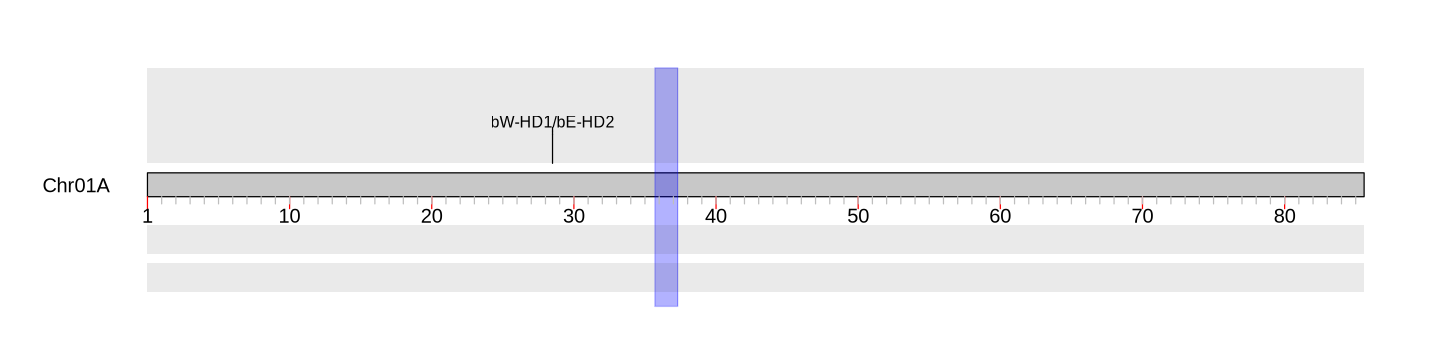

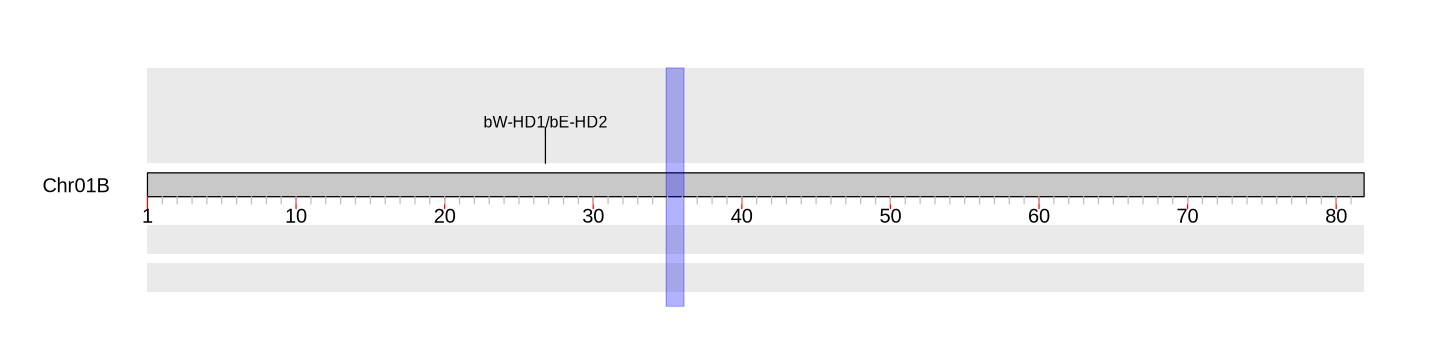

In [23]:
for (i in unique(HD_gene.gff$seqname)){
    options(repr.plot.width=12, repr.plot.height=3)
    tmp_gene <-gff%>%filter(seqname == as.character(i))
    tmp_label <-HD_gene.gff%>%filter(seqname == as.character(i))%>%filter(grepl('bW', gene_type))%>%select(seqname, start, end, gene_type)%>%toGRanges
    tmp_cytoband_gene <- tmp_gene %>% mutate(start=as.numeric(start), end=as.numeric(end)) %>%mutate(gieStain="gpos50")%>%select(seqname, start, end, attribute, gieStain)
    tmp_cytoband_inter <- tmp_gene%>%mutate(start=as.numeric(start), end=as.numeric(end))%>%arrange(seqname, start)%>%
        mutate(Line = ifelse(row_number() == 1, "First", ifelse(row_number() == n (), "Last", "FALSE")))%>%
        mutate(Inter_start = ifelse(Line=="First", 1,  lag(end) + 1))%>%
            mutate(Inter_end = start-1)%>%
            select("seqname","Inter_start","Inter_end")%>%
            mutate(name = "int", gieStain = "gneg")
    colnames(tmp_cytoband_inter)<-c("chr", "start", "end", "gene", "gieStain")
    colnames(tmp_cytoband_gene)<-c("chr", "start", "end", "gene", "gieStain")
    tmp_cytoband <- rbind(tmp_cytoband_gene, tmp_cytoband_inter)
    tmp_cytoband_gene<-tmp_cytoband_gene%>%toGRanges
    tmp_genome <-genome%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))%>%
        as.data.frame%>%toGRanges
    tmp_cen <-cen%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
    HD_whole<-plotKaryotype(plot.type=2, genome=tmp_genome)
    kpPlotRegions(HD_whole, data=tmp_cen, r0=-1.5, r1=1, col = rgb(0, 0, 1, 0.3))
    kpAddBaseNumbers(HD_whole, tick.dist = 10000000, tick.len = 25, tick.col="red", cex=1,
                 minor.tick.dist = 1000000, minor.tick.len = 15, minor.tick.col = "gray")
    kpDataBackground(HD_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.6, r1=0.9)
    kpDataBackground(HD_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.2, r1=0.5)
    kpDataBackground(HD_whole, data.panel = 1, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0, r1=1)
    kpPlotMarkers(HD_whole, data=tmp_label, labels="bW-HD1/bE-HD2", text.orientation = "horizontal",
              r1=0.5, cex=0.8, adjust.label.position = FALSE)
}

No predefined canonical chromosomes found for the requested genome. Applying a heuristic chromosome filtering.

To get the unfiltered genome, please set chromosomes="all" in the plotKaryotype call



$plot.params
$plot.params$leftmargin
[1] 0.1

$plot.params$rightmargin
[1] 0.05

$plot.params$topmargin
[1] 120

$plot.params$bottommargin
[1] 100

$plot.params$ideogramheight
[1] 50

$plot.params$ideogramlateralmargin
[1] 0

$plot.params$data1height
[1] 200

$plot.params$data1inmargin
[1] 20

$plot.params$data1outmargin
[1] 20

$plot.params$data1min
[1] 0

$plot.params$data1max
[1] 1

$plot.params$data2height
[1] 200

$plot.params$data2inmargin
[1] 20

$plot.params$data2outmargin
[1] 20

$plot.params$data2min
[1] 0

$plot.params$data2max
[1] 1

$plot.params$dataideogrammin
[1] 0

$plot.params$dataideogrammax
[1] 1

$plot.params$dataallmin
[1] 0

$plot.params$dataallmax
[1] 1


$genome.name
[1] "custom"

$genome
GRanges object with 1 range and 0 metadata columns:
         seqnames     ranges strand
            <Rle>  <IRanges>  <Rle>
  Chr05A   Chr05A 1-69948377      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

$plot.type
[1] 2

$plot.region
GRanges obje

No predefined canonical chromosomes found for the requested genome. Applying a heuristic chromosome filtering.

To get the unfiltered genome, please set chromosomes="all" in the plotKaryotype call



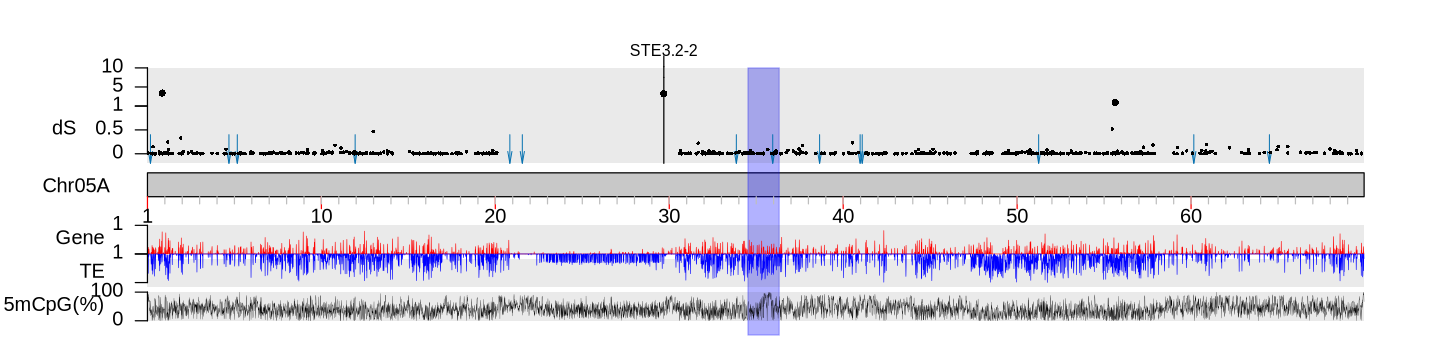

$plot.params
$plot.params$leftmargin
[1] 0.1

$plot.params$rightmargin
[1] 0.05

$plot.params$topmargin
[1] 120

$plot.params$bottommargin
[1] 100

$plot.params$ideogramheight
[1] 50

$plot.params$ideogramlateralmargin
[1] 0

$plot.params$data1height
[1] 200

$plot.params$data1inmargin
[1] 20

$plot.params$data1outmargin
[1] 20

$plot.params$data1min
[1] 0

$plot.params$data1max
[1] 1

$plot.params$data2height
[1] 200

$plot.params$data2inmargin
[1] 20

$plot.params$data2outmargin
[1] 20

$plot.params$data2min
[1] 0

$plot.params$data2max
[1] 1

$plot.params$dataideogrammin
[1] 0

$plot.params$dataideogrammax
[1] 1

$plot.params$dataallmin
[1] 0

$plot.params$dataallmax
[1] 1


$genome.name
[1] "custom"

$genome
GRanges object with 1 range and 0 metadata columns:
         seqnames     ranges strand
            <Rle>  <IRanges>  <Rle>
  Chr05B   Chr05B 1-70239414      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

$plot.type
[1] 2

$plot.region
GRanges obje

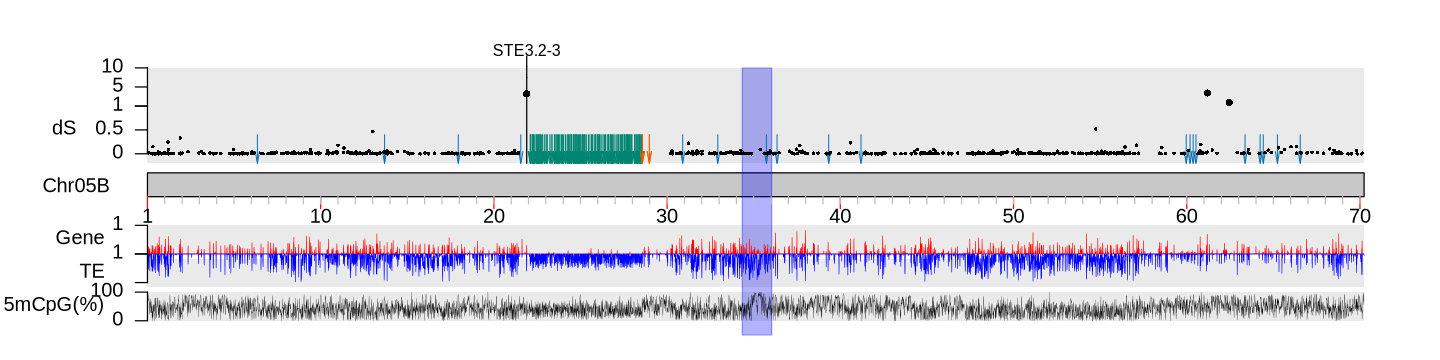

In [24]:
for (i in unique(PR_gene.gff$seqname)){
    options(repr.plot.width=12, repr.plot.height=3)
    #svg(paste0(i, '_PR_whole.svg'), width=12, height=3)
    tmp_gene <-gff%>%filter(seqname == as.character(i))
    tmp_label <-PR_gene.gff%>%filter(seqname == as.character(i))%>%select(seqname, start, end, gene_type)%>%toGRanges
    tmp_cytoband_gene <- tmp_gene %>% mutate(start=as.numeric(start), end=as.numeric(end)) %>%mutate(gieStain="gpos50")%>%select(seqname, start, end, attribute, gieStain)
    tmp_cytoband_inter <- tmp_gene%>%mutate(start=as.numeric(start), end=as.numeric(end))%>%arrange(seqname, start)%>%
        mutate(Line = ifelse(row_number() == 1, "First", ifelse(row_number() == n (), "Last", "FALSE")))%>%
        mutate(Inter_start = ifelse(Line=="First", 1,  lag(end) + 1))%>%
            mutate(Inter_end = start-1)%>%
            select("seqname","Inter_start","Inter_end")%>%
            mutate(name = "int", gieStain = "gneg")
    tmp_dS<-PR_dS%>%filter(seqname1 == as.character(i)|seqname2 == as.character(i))
    tmp_gene_den<-calculate_cov(genome = genome, window_size = 10000, gff = gff, chr = as.character(i))
    tmp_TE_den<-calculate_cov(genome = genome, window_size = 10000, gff = TE, chr = as.character(i))
    #tmp_CpG_den<-calculate_cov(genome = genome, window_size = 50, gff = bed_5mCpG, chr = as.character(i))
    tmp_CpG_den<-cov_5mCpG(genome = genome, window_size = 10000, chr = as.character(i), CpG_bed = CpG_bed, bed_5mCpG = bed_5mCpG)
#    tmp_6mA_den<-calculate_cov(genome = genome, window_size = 50, gff = bed_6mA, chr = as.character(i))
    if(unique(tmp_dS$seqname1) ==as.character(i)){
        tmp_dS <-tmp_dS%>%select(seqname1, start1, end1, dS)
        colnames(tmp_dS) <-c("chr", "start", "end", "dS")
    }else{
        tmp_dS <-tmp_dS%>%select(seqname2, start2, end2, dS)
        colnames(tmp_dS) <-c("chr", "start", "end", "dS")
    }    
    tmp_dS0 <-tmp_dS%>%filter(dS < 1)
    tmp_dS1 <-tmp_dS%>%filter(dS >= 1)
    colnames(tmp_cytoband_inter)<-c("chr", "start", "end", "gene", "gieStain")
    colnames(tmp_cytoband_gene)<-c("chr", "start", "end", "gene", "gieStain")
    tmp_cytoband <- rbind(tmp_cytoband_gene, tmp_cytoband_inter) %>%filter(end > start)%>%toGRanges
    tmp_cytoband_gene<-tmp_cytoband_gene%>%toGRanges
    tmp_genome <-genome%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))%>%
        as.data.frame%>%toGRanges
    tmp_cen <-cen%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
    PR_whole<-plotKaryotype(plot.type=2, genome=tmp_genome)
    kpPlotRegions(PR_whole, data=tmp_cen, r0=-1.8, r1=1, col = rgb(0, 0, 1, 0.3))
    kpAddBaseNumbers(PR_whole, tick.dist = 10000000, tick.len = 25, tick.col="red", cex=1,
                 minor.tick.dist = 1000000, minor.tick.len = 15, minor.tick.col = "gray")
    kpDataBackground(PR_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.55, r1=0.85)
    kpDataBackground(PR_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.2, r1=0.5)
    kpDataBackground(PR_whole, data.panel = 1, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0, r1=1)
    kpDataBackground(PR_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.9, r1=1.2) #<-------track for methylation
 #   kpDataBackground(PR_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =1.2, r1=1.5)
    kpPlotMarkers(PR_whole, data=tmp_label, labels=tmp_label$gene_type, text.orientation = "horizontal",
              r1=1.5, cex=0.8, adjust.label.position = FALSE)
    if (i == 'Chr05A'){
        mfa_tmp <-mfa_bed%>%filter(chrom == as.character(i))
        kpArrows(PR_whole, chr=as.character(i), x0=mfa_tmp$start, x1=mfa_tmp$start, y0 = 0.3,y1 = 0, col=mfa_tmp$color, lwd=0.8, angle=10, length=0.1)
    }else{
        mfa_tmp <-mfa_bed%>%filter(chrom == as.character(i))
        kpArrows(PR_whole, chr=as.character(i), x0=mfa_tmp$start, x1=mfa_tmp$start, y0 = 0.3,y1 = 0, col=mfa_tmp$color, lwd=0.8, angle=10, length=0.1)
    }
    kpPoints(PR_whole, chr=as.character(i), x=(tmp_dS0$start+tmp_dS0$end)/2, y=tmp_dS0$dS, data.panel = 1, r0=0.1, r1=0.6, cex=0.4)
    kpPoints(PR_whole, chr=as.character(i), x=(tmp_dS1$start+tmp_dS1$end)/2, y=(tmp_dS1$dS-1)/10, data.panel = 1, r0=0.6, r1=1, cex=0.8)
    
    kpAxis(PR_whole, data.panel=1, side = 1, ymin=0, ymax=1,r0=0.1, r1=0.6)
    kpAxis(PR_whole, data.panel=1, side = 1, ymin=0, ymax=1,r0=0.6, r1=1,tick.pos = c(0, 0.5, 1), labels = c(" ", 5, 10))
    kpLines(PR_whole, chr=as.character(i), x=(tmp_gene_den$start+tmp_gene_den$end)/2, y=(1-tmp_gene_den$coverage_percent), data.panel = 2, r0 =0.2, r1=0.5, col="red",ymin=0, ymax=1, lwd=0.5)
    kpLines(PR_whole, chr=as.character(i), x=(tmp_TE_den$start+tmp_TE_den$end)/2, y=(tmp_TE_den$coverage_percent), data.panel = 2, r0 =0.8, r1=0.5, col="blue",ymin=0, ymax=1, lwd=0.5)
    kpLines(PR_whole, chr=as.character(i), x=(tmp_CpG_den$start+tmp_CpG_den$end)/2, y=(tmp_CpG_den$m_per_CpG), data.panel = 2, r0 =1.2, r1=0.9, col="black",ymin=0, ymax=1, lwd=0.2)
#     kpLines(PR_whole, chr=as.character(i), x=(tmp_6mA_den$start+tmp_6mA_den$end)/2, y=((1-tmp_6mA_den$coverage_percent)), data.panel = 2, r0 =1.2, r1=1.5, col="black",ymin=0, ymax=1, lwd=0.5)
    kpAxis(PR_whole, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1," "), r0 =0.2, r1=0.5)
    kpAxis(PR_whole, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1," "), r0 =0.5, r1=0.8)
    kpAxis(PR_whole, data.panel=2, side = 1, numticks = 2, tick.pos = c(0,1),labels = c(100, 0), r0 =0.9, r1=1.2)
    kpAddLabels(PR_whole, labels="Gene", data.panel = 2, r0 =0.2, r1=0.5,label.margin = 0.03)
    kpAddLabels(PR_whole, labels="TE", data.panel = 2, r0 =0.55, r1=0.85,label.margin = 0.03)
    kpAddLabels(PR_whole, labels="dS", data.panel = 1, r0 =0.2, r1=0.5,label.margin = 0.05)
    kpAddLabels(PR_whole, labels="5mCpG(%)", data.panel = 2, r0 =0.9, r1=1.2,label.margin = 0.03)
#Save figure as svg
    print(PR_whole)
   # dev.off()
}
#---------------------------------
#---------------------------------


In [56]:
tmp_CpG_den<-cov_5mCpG(genome = genome, window_size = 10000, chr = as.character(i), CpG_bed = CpG_bed, bed_5mCpG = bed_5mCpG)

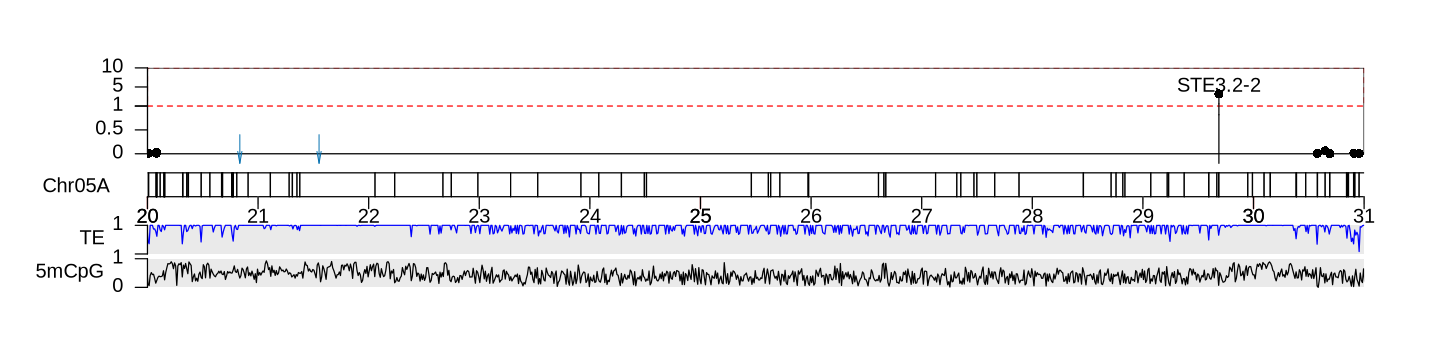

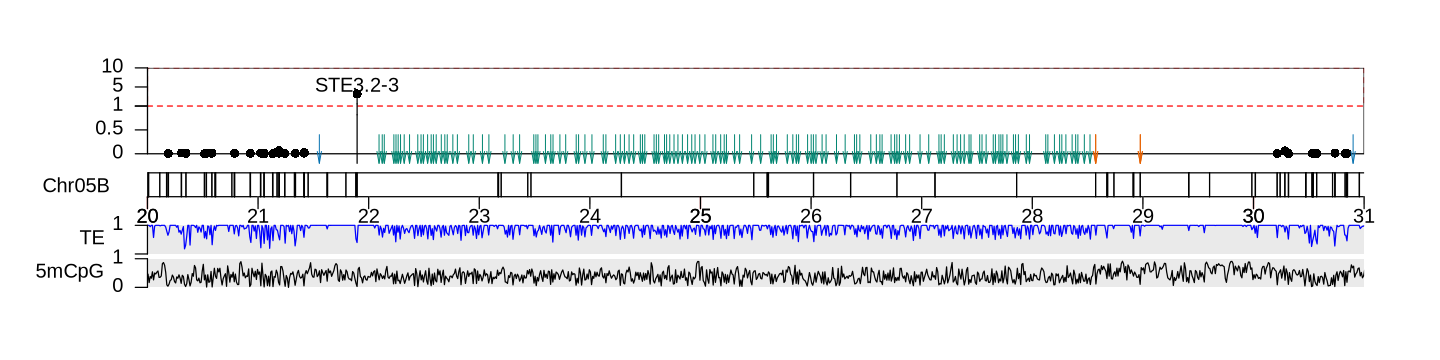

In [25]:
for (i in unique(PR_gene.gff$seqname)){
    options(repr.plot.width=12, repr.plot.height=3)
 #   svg(paste0(i, '_PR_partial.svg'), width=12, height=3)
    tmp_gene <-gff%>%filter(seqname == as.character(i))
    tmp_label <-PR_gene.gff%>%filter(seqname == as.character(i))%>%select(seqname, start, end, gene_type)%>%toGRanges
    tmp_cytoband_gene <- tmp_gene %>% mutate(start=as.numeric(start), end=as.numeric(end)) %>%mutate(gieStain="gpos50")%>%select(seqname, start, end, attribute, gieStain)
    tmp_cytoband_inter <- tmp_gene%>%mutate(start=as.numeric(start), end=as.numeric(end))%>%arrange(seqname, start)%>%
        mutate(Line = ifelse(row_number() == 1, "First", ifelse(row_number() == n (), "Last", "FALSE")))%>%
        mutate(Inter_start = ifelse(Line=="First", 1,  lag(end) + 1))%>%
            mutate(Inter_end = start-1)%>%
            select("seqname","Inter_start","Inter_end")%>%
            mutate(name = "int", gieStain = "gneg")
    tmp_dS<-PR_dS%>%filter(seqname1 == as.character(i)|seqname2 == as.character(i))
    tmp_gene_den<-calculate_cov(genome = genome, window_size = 10000, gff = gff, chr = as.character(i))
    tmp_TE_den<-calculate_cov(genome = genome, window_size = 10000, gff = TE, chr = as.character(i))
    #tmp_CpG_den<-bed_5mCpG%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
    #tmp_CpG_den<-calculate_cov(genome = genome, window_size = 50, gff = bed_5mCpG, chr = as.character(i))# %>%filter(coverage_percent >0)
    tmp_CpG_den<-cov_5mCpG(genome = genome, window_size = 10000, chr = as.character(i), CpG_bed = CpG_bed, bed_5mCpG = bed_5mCpG)
#    tmp_6mA_den<-calculate_cov(genome = genome, window_size = 500, gff = bed_6mA, chr = as.character(i)) %>%filter(coverage_percent >0)
    if(unique(tmp_dS$seqname1) ==as.character(i)){
        tmp_dS <-tmp_dS%>%select(seqname1, start1, end1, dS)
        colnames(tmp_dS) <-c("chr", "start", "end", "dS")
    }else{
        tmp_dS <-tmp_dS%>%select(seqname2, start2, end2, dS)
        colnames(tmp_dS) <-c("chr", "start", "end", "dS")
    }    
    tmp_dS0 <-tmp_dS%>%filter(dS < 1)
    tmp_dS1 <-tmp_dS%>%filter(dS >= 1)
    colnames(tmp_cytoband_inter)<-c("chr", "start", "end", "gene", "gieStain")
    colnames(tmp_cytoband_gene)<-c("chr", "start", "end", "gene", "gieStain")
    tmp_cytoband <- rbind(tmp_cytoband_gene, tmp_cytoband_inter) %>%filter(end > start)%>%toGRanges
    tmp_cytoband_gene<-tmp_cytoband_gene%>%toGRanges
    tmp_genome <-genome%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))%>%
        as.data.frame%>%toGRanges
    tmp_cen <-cen%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
        PR_zoom<-genome%>%filter(seqname == as.character(i))%>%mutate(start = 20000000)%>%mutate(end = 31000000)%>%
        as.data.frame%>%toGRanges
    tmp_kp<- plotKaryotype(chromosomes=as.character(i), genome = tmp_genome, zoom=PR_zoom, plot.type=2, cytobands=tmp_cytoband)
    kpAddBaseNumbers(tmp_kp, tick.dist = 5000000, tick.len = 25, tick.col="red", cex=1,
                 minor.tick.dist = 1000000, minor.tick.len = 15, minor.tick.col = "gray")
    kpAddBaseNumbers(tmp_kp, tick.dist = 1000000, tick.len = 25, tick.col="black", cex=0)             
    tmp_cen <-tmp_cen%>%toGRanges
    kpPlotRegions(tmp_kp, data=tmp_cen, r0=-1.4, r1=1, col = rgb(0, 0, 1, 0.3))
    #Back ground of ds value 
#    kpDataBackground(tmp_kp, data.panel = 1, col=rgb(0, 1, 1, 0.1),r0=0, r1=0.6)
    kpRect(tmp_kp, chr=i, x0=20000000, x1=31000000, y0=0.6, y1=1, col="NA", data.panel=1, border="red",lty=2)
    kpRect(tmp_kp, chr=i, x0=20000000, x1=31000000, y0=0.1, y1=1, col="NA", data.panel=1, border="black")
    tmp2<-tmp_dS0
    kpPoints(tmp_kp, chr=as.character(i), x=(tmp2$start+tmp2$end)/2, y=tmp2$dS, data.panel = 1, r0=0.1, r1=0.6, cex=1)
    tmp3<-tmp_dS1
    kpPoints(tmp_kp, chr=as.character(i), x=(tmp3$start+tmp3$end)/2, y=(tmp3$dS-1)/10, data.panel = 1, r0=0.6, r1=1, cex=1)
    #kpAxis(tmp_kp, data.panel=1, side = 1, numticks = 5, ymin=0, ymax=1,r0=0.1, r1=0.6)
    kpAxis(tmp_kp, data.panel=1, side = 1, ymin=0, ymax=1,r0=0.1, r1=0.6)
    kpAxis(tmp_kp, data.panel=1, side = 1, ymin=0, ymax=1,r0=0.6, r1=1,tick.pos = c(0, 0.5, 1), labels = c(" ", 5, 10))
    kpPlotMarkers(tmp_kp, data=tmp_label, labels=tmp_label$gene_type, text.orientation = "horizontal", marker.parts = c(4, 0.9, 1), max.iter = 1000)
    if (i == 'Chr05A'){
        mfa_tmp <-mfa_bed%>%filter(chrom == as.character(i))
        kpArrows(tmp_kp, chr=as.character(i), x0=mfa_tmp$start, x1=mfa_tmp$start, y0 = 0.3,y1 = 0, col=mfa_tmp$color, lwd=0.8, angle=10, length=0.1)
    }else{
        mfa_tmp <-mfa_bed%>%filter(chrom == as.character(i))
        kpArrows(tmp_kp, chr=as.character(i), x0=mfa_tmp$start, x1=mfa_tmp$start, y0 = 0.3,y1 = 0, col=mfa_tmp$color, lwd=0.8, angle=10, length=0.1)
    }
    kpDataBackground(tmp_kp, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.55, r1=0.85)
    kpDataBackground(tmp_kp, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.2, r1=0.5)
 #   kpDataBackground(tmp_kp, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.9, r1=1.2)
  #  kpDataBackground(tmp_kp, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =1.2, r1=1.5)
  #  kpLines(tmp_kp, chr=as.character(i), x=(tmp_gene_den$start+tmp_gene_den$end)/2, y=(1-tmp_gene_den$coverage_percent), data.panel = 2, r0 =0.2, r1=0.5, col="red",ymin=0, ymax=1)
    kpLines(tmp_kp, chr=as.character(i), x=(tmp_TE_den$start+tmp_TE_den$end)/2, y=(tmp_TE_den$coverage_percent), data.panel = 2, r0 =0.5, r1=0.2, col="blue",ymin=0, ymax=1)
     kpLines(tmp_kp, chr=as.character(i), x=(tmp_CpG_den$start+tmp_CpG_den$end)/2, y=(tmp_CpG_den$m_per_CpG), data.panel = 2, r0 =0.85, r1=0.55, col="black",ymin=0, ymax=1)
  #  kpBars(tmp_kp, chr=as.character(i), x0=tmp_CpG_den$start, x1=tmp_CpG_den$end, y1=(100-(tmp_CpG_den$coverage)), data.panel = 2, r0 =0.55, r1=0.85, col="black",ymin=0, ymax=100, border=NA)
 #   tmp_CpG_den<-tmp_CpG_den%>%select(c('seqname', 'start', 'end'))%>%as.data.frame %>%toGRanges
    #kpPlotCoverage(tmp_kp, data=tmp_CpG_den, data.panel = 2, r0=0.55, r1=0.85, col="black", border=NA)
  #  kpPlotDensity(tmp_kp, data=tmp_CpG_den, data.panel = 2, r0=0.55, r1=0.85, window.size = 500)
    #kpLines(tmp_kp, chr=as.character(i), x=(tmp_6mA_den$start+tmp_6mA_den$end)/2, y=((1-tmp_6mA_den$coverage_percent)), data.panel = 2, r0 =1.2, r1=1.5, col="black",ymin=0, ymax=1)
 #   kpAxis(tmp_kp, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1, " "), r0 =0.2, r1=0.5)
    kpAxis(tmp_kp, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1, " "), r0 =0.2, r1=0.5)
    kpAxis(tmp_kp, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1, 0), r0 =0.55, r1=0.85)
  #  kpAxis(tmp_kp, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1, " "), r0 =1.2, r1=1.5)
    kpAddLabels(tmp_kp, labels="TE", data.panel = 2, r0 =0.2, r1=0.5,label.margin = 0.03)
    kpAddLabels(tmp_kp, labels="5mCpG", data.panel = 2, r0 =0.55, r1=0.85,label.margin = 0.03)
 #   dev.off()
}

No predefined canonical chromosomes found for the requested genome. Applying a heuristic chromosome filtering.

To get the unfiltered genome, please set chromosomes="all" in the plotKaryotype call

No predefined canonical chromosomes found for the requested genome. Applying a heuristic chromosome filtering.

To get the unfiltered genome, please set chromosomes="all" in the plotKaryotype call



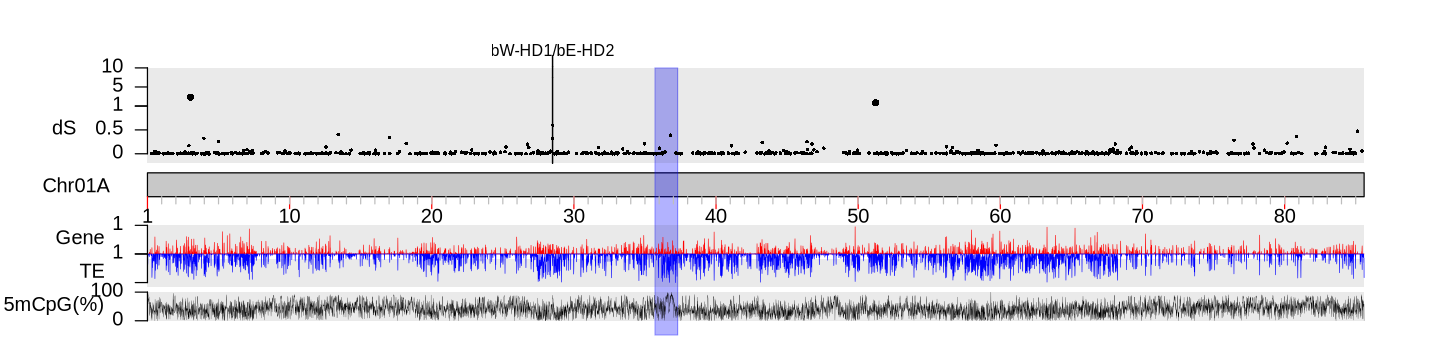

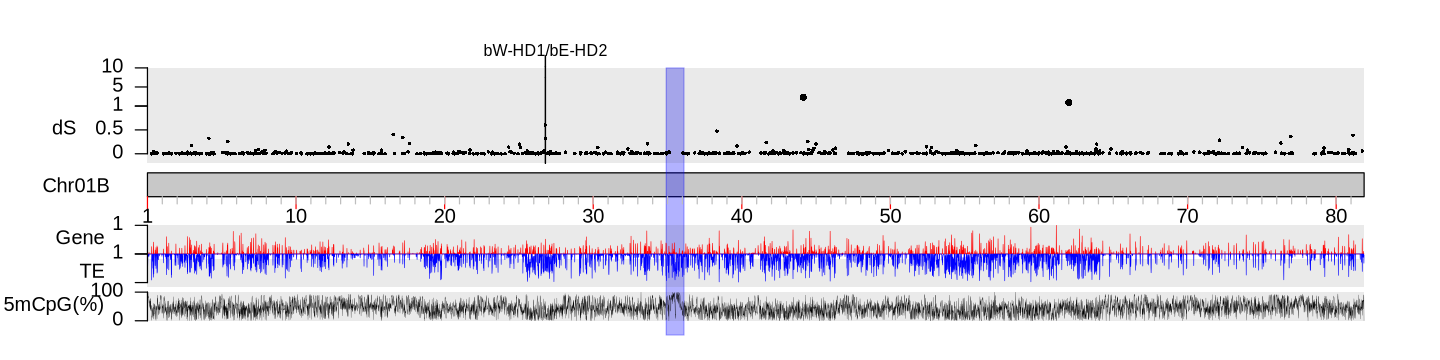

In [26]:
for (i in unique(HD_gene.gff$seqname)){
    options(repr.plot.width=12, repr.plot.height=3)
 #   svg(paste0(i, '_HD_whole.svg'), width=12, height=3)
    tmp_gene <-gff%>%filter(seqname == as.character(i))
    tmp_label <-HD_gene.gff%>%filter(seqname == as.character(i))%>%select(seqname, start, end, gene_type)%>%toGRanges
    tmp_cytoband_gene <- tmp_gene %>% mutate(start=as.numeric(start), end=as.numeric(end)) %>%mutate(gieStain="gpos50")%>%select(seqname, start, end, attribute, gieStain)
    tmp_cytoband_inter <- tmp_gene%>%mutate(start=as.numeric(start), end=as.numeric(end))%>%arrange(seqname, start)%>%
        mutate(Line = ifelse(row_number() == 1, "First", ifelse(row_number() == n (), "Last", "FALSE")))%>%
        mutate(Inter_start = ifelse(Line=="First", 1,  lag(end) + 1))%>%
            mutate(Inter_end = start-1)%>%
            select("seqname","Inter_start","Inter_end")%>%
            mutate(name = "int", gieStain = "gneg")
    tmp_dS<-HD_dS%>%filter(seqname1 == as.character(i)|seqname2 == as.character(i))
    tmp_gene_den<-calculate_cov(genome = genome, window_size = 10000, gff = gff, chr = as.character(i))
    tmp_TE_den<-calculate_cov(genome = genome, window_size = 10000, gff = TE, chr = as.character(i))
   # tmp_CpG_den<-calculate_cov(genome = genome, window_size = 50, gff = bed_5mCpG, chr = as.character(i))
    tmp_CpG_den<-cov_5mCpG(genome = genome, window_size = 10000, chr = as.character(i), CpG_bed = CpG_bed, bed_5mCpG = bed_5mCpG)
#    tmp_6mA_den<-calculate_cov(genome = genome, window_size = 50, gff = bed_6mA, chr = as.character(i))
    if(unique(tmp_dS$seqname1) ==as.character(i)){
        tmp_dS <-tmp_dS%>%select(seqname1, start1, end1, dS)
        colnames(tmp_dS) <-c("chr", "start", "end", "dS")
    }else{
        tmp_dS <-tmp_dS%>%select(seqname2, start2, end2, dS)
        colnames(tmp_dS) <-c("chr", "start", "end", "dS")
    }    
    tmp_dS0 <-tmp_dS%>%filter(dS < 1)
    tmp_dS1 <-tmp_dS%>%filter(dS >= 1)
    colnames(tmp_cytoband_inter)<-c("chr", "start", "end", "gene", "gieStain")
    colnames(tmp_cytoband_gene)<-c("chr", "start", "end", "gene", "gieStain")
    tmp_cytoband <- rbind(tmp_cytoband_gene, tmp_cytoband_inter) %>%filter(end > start)%>%toGRanges
    tmp_cytoband_gene<-tmp_cytoband_gene%>%toGRanges
    tmp_genome <-genome%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))%>%
        as.data.frame%>%toGRanges
    tmp_cen <-cen%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
    HD_whole<-plotKaryotype(plot.type=2, genome=tmp_genome)
    kpPlotRegions(HD_whole, data=tmp_cen, r0=-1.8, r1=1, col = rgb(0, 0, 1, 0.3))
    kpAddBaseNumbers(HD_whole, tick.dist = 10000000, tick.len = 25, tick.col="red", cex=1,
                 minor.tick.dist = 1000000, minor.tick.len = 15, minor.tick.col = "gray")
    kpDataBackground(HD_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.55, r1=0.85)
    kpDataBackground(HD_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.2, r1=0.5)
    kpDataBackground(HD_whole, data.panel = 1, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0, r1=1)
    kpDataBackground(HD_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.9, r1=1.2) #<-------track for methylation
 #   kpDataBackground(HD_whole, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =1.2, r1=1.5)
    kpPoints(HD_whole, chr=as.character(i), x=(tmp_dS0$start+tmp_dS0$end)/2, y=tmp_dS0$dS, data.panel = 1, r0=0.1, r1=0.6, cex=0.4)
    kpPoints(HD_whole, chr=as.character(i), x=(tmp_dS1$start+tmp_dS1$end)/2, y=(tmp_dS1$dS-1)/10, data.panel = 1, r0=0.6, r1=1, cex=0.8)
    
    kpAxis(HD_whole, data.panel=1, side = 1, ymin=0, ymax=1,r0=0.1, r1=0.6)
    kpAxis(HD_whole, data.panel=1, side = 1, ymin=0, ymax=1,r0=0.6, r1=1,tick.pos = c(0, 0.5, 1), labels = c(" ", 5, 10))
    kpLines(HD_whole, chr=as.character(i), x=(tmp_gene_den$start+tmp_gene_den$end)/2, y=(tmp_gene_den$coverage_percent), data.panel = 2, r0 =0.5, r1=0.2, col="red",ymin=0, ymax=1, lwd=0.5)
    kpLines(HD_whole, chr=as.character(i), x=(tmp_TE_den$start+tmp_TE_den$end)/2, y=(tmp_TE_den$coverage_percent), data.panel = 2, r0 =0.8, r1=0.5, col="blue",ymin=0, ymax=1, lwd=0.5)
    kpLines(HD_whole, chr=as.character(i), x=(tmp_CpG_den$start+tmp_CpG_den$end)/2, y=(tmp_CpG_den$m_per_CpG), data.panel = 2, r0 =1.2, r1=0.9, col="black",ymin=0, ymax=1, lwd=0.2)
#     kpLines(HD_whole, chr=as.character(i), x=(tmp_6mA_den$start+tmp_6mA_den$end)/2, y=((1-tmp_6mA_den$coverage_percent)), data.panel = 2, r0 =1.2, r1=1.5, col="black",ymin=0, ymax=1, lwd=0.5)
    kpAxis(HD_whole, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1," "), r0 =0.2, r1=0.5)
    kpAxis(HD_whole, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1," "), r0 =0.5, r1=0.8)
    kpAxis(HD_whole, data.panel=2, side = 1, numticks = 2, tick.pos = c(0,1),labels = c(100, 0), r0 =0.9, r1=1.2)
    kpAddLabels(HD_whole, labels="Gene", data.panel = 2, r0 =0.2, r1=0.5,label.margin = 0.03)
    kpAddLabels(HD_whole, labels="TE", data.panel = 2, r0 =0.55, r1=0.85,label.margin = 0.03)
    kpAddLabels(HD_whole, labels="dS", data.panel = 1, r0 =0.2, r1=0.5,label.margin = 0.05)
    kpAddLabels(HD_whole, labels="5mCpG(%)", data.panel = 2, r0 =0.9, r1=1.2,label.margin = 0.03)
    kpPlotMarkers(HD_whole, data=tmp_label, labels="bW-HD1/bE-HD2", text.orientation = "horizontal",
              r1=1.5, cex=0.8, adjust.label.position = FALSE)
  #  dev.off()
#---------------------------------
#---------------------------------
}

In [ ]:
for (i in unique(HD_gene.gff$seqname)){
    options(repr.plot.width=12, repr.plot.height=3)
    svg(paste0(i, '_HD_partial.svg'), width=12, height=3)
    tmp_gene <-gff%>%filter(seqname == as.character(i))
    tmp_label <-HD_gene.gff%>%filter(seqname == as.character(i))%>%select(seqname, start, end, gene_type)%>%toGRanges
    tmp_cytoband_gene <- tmp_gene %>% mutate(start=as.numeric(start), end=as.numeric(end)) %>%mutate(gieStain="gpos50")%>%select(seqname, start, end, attribute, gieStain)
    tmp_cytoband_inter <- tmp_gene%>%mutate(start=as.numeric(start), end=as.numeric(end))%>%arrange(seqname, start)%>%
        mutate(Line = ifelse(row_number() == 1, "First", ifelse(row_number() == n (), "Last", "FALSE")))%>%
        mutate(Inter_start = ifelse(Line=="First", 1,  lag(end) + 1))%>%
            mutate(Inter_end = start-1)%>%
            select("seqname","Inter_start","Inter_end")%>%
            mutate(name = "int", gieStain = "gneg")
    tmp_dS<-HD_dS%>%filter(seqname1 == as.character(i)|seqname2 == as.character(i))
    tmp_gene_den<-calculate_cov(genome = genome, window_size = 10000, gff = gff, chr = as.character(i))
    tmp_TE_den<-calculate_cov(genome = genome, window_size = 10000, gff = TE, chr = as.character(i))
    #tmp_CpG_den<-bed_5mCpG%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
   # tmp_CpG_den<-calculate_cov(genome = genome, window_size = 50, gff = bed_5mCpG, chr = as.character(i))# %>%filter(coverage_percent >0)
    tmp_CpG_den<-cov_5mCpG(genome = genome, window_size = 10000, chr = as.character(i), CpG_bed = CpG_bed, bed_5mCpG = bed_5mCpG)
#    tmp_6mA_den<-calculate_cov(genome = genome, window_size = 500, gff = bed_6mA, chr = as.character(i)) %>%filter(coverage_percent >0)
    if(unique(tmp_dS$seqname1) ==as.character(i)){
        tmp_dS <-tmp_dS%>%select(seqname1, start1, end1, dS)
        colnames(tmp_dS) <-c("chr", "start", "end", "dS")
    }else{
        tmp_dS <-tmp_dS%>%select(seqname2, start2, end2, dS)
        colnames(tmp_dS) <-c("chr", "start", "end", "dS")
    }    
    tmp_dS0 <-tmp_dS%>%filter(dS < 1)
    tmp_dS1 <-tmp_dS%>%filter(dS >= 1)
    colnames(tmp_cytoband_inter)<-c("chr", "start", "end", "gene", "gieStain")
    colnames(tmp_cytoband_gene)<-c("chr", "start", "end", "gene", "gieStain")
    tmp_cytoband <- rbind(tmp_cytoband_gene, tmp_cytoband_inter) %>%filter(end > start)%>%toGRanges
    tmp_cytoband_gene<-tmp_cytoband_gene%>%toGRanges
    tmp_genome <-genome%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))%>%
        as.data.frame%>%toGRanges
    tmp_cen <-cen%>%filter(seqname == as.character(i))%>%mutate(start = as.numeric(start))%>%mutate(end = as.numeric(end))
        HD_zoom<-genome%>%filter(seqname == as.character(i))%>%mutate(start = 26000000)%>%mutate(end = 30000000)%>%
        as.data.frame%>%toGRanges
    tmp_kp<- plotKaryotype(chromosomes=as.character(i), genome = tmp_genome, zoom=HD_zoom, plot.type=2, cytobands=tmp_cytoband)
    kpAddBaseNumbers(tmp_kp, tick.dist = 5000000, tick.len = 25, tick.col="red", cex=1,
                 minor.tick.dist = 1000000, minor.tick.len = 15, minor.tick.col = "gray")
    kpAddBaseNumbers(tmp_kp, tick.dist = 1000000, tick.len = 25, tick.col="black", cex=0)             
    tmp_cen <-tmp_cen%>%toGRanges
    kpPlotRegions(tmp_kp, data=tmp_cen, r0=-1.4, r1=1, col = rgb(0, 0, 1, 0.3))
    #Back ground of ds value 
#    kpDataBackground(tmp_kp, data.panel = 1, col=rgb(0, 1, 1, 0.1),r0=0, r1=0.6)
    kpRect(tmp_kp, chr=i, x0=26000000, x1=30000000, y0=0.6, y1=1, col="NA", data.panel=1, border="red",lty=2)
    kpRect(tmp_kp, chr=i, x0=26000000, x1=30000000, y0=0.1, y1=1, col="NA", data.panel=1, border="black")
    tmp2<-tmp_dS0
    kpPoints(tmp_kp, chr=as.character(i), x=(tmp2$start+tmp2$end)/2, y=tmp2$dS, data.panel = 1, r0=0.1, r1=0.6, cex=1)
    tmp3<-tmp_dS1
    kpPoints(tmp_kp, chr=as.character(i), x=(tmp3$start+tmp3$end)/2, y=(tmp3$dS-1)/10, data.panel = 1, r0=0.6, r1=1, cex=1)
    #kpAxis(tmp_kp, data.panel=1, side = 1, numticks = 5, ymin=0, ymax=1,r0=0.1, r1=0.6)
    kpAxis(tmp_kp, data.panel=1, side = 1, ymin=0, ymax=1,r0=0.1, r1=0.6)
    kpAxis(tmp_kp, data.panel=1, side = 1, ymin=0, ymax=1,r0=0.6, r1=1,tick.pos = c(0, 0.5, 1), labels = c(" ", 5, 10))
    kpPlotMarkers(tmp_kp, data=tmp_label, labels=tmp_label$gene_type, text.orientation = "horizontal", marker.parts = c(4, 0.9, 1), max.iter = 1000)
    kpDataBackground(tmp_kp, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.55, r1=0.85)
    kpDataBackground(tmp_kp, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.2, r1=0.5)
 #   kpDataBackground(tmp_kp, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =0.9, r1=1.2)
  #  kpDataBackground(tmp_kp, data.panel = 2, col=rgb(0.219, 0.216, 0.206, 0.1),r0 =1.2, r1=1.5)
  #  kpLines(tmp_kp, chr=as.character(i), x=(tmp_gene_den$start+tmp_gene_den$end)/2, y=(1-tmp_gene_den$coverage_percent), data.panel = 2, r0 =0.2, r1=0.5, col="red",ymin=0, ymax=1)
    kpLines(tmp_kp, chr=as.character(i), x=(tmp_TE_den$start+tmp_TE_den$end)/2, y=(tmp_TE_den$coverage_percent), data.panel = 2, r0 =0.5, r1=0.2, col="blue",ymin=0, ymax=1)
    kpLines(tmp_kp, chr=as.character(i), x=(tmp_CpG_den$start+tmp_CpG_den$end)/2, y=(tmp_CpG_den$m_per_CpG), data.panel = 2, r0 =0.85, r1=0.55, col="black",ymin=0, ymax=1)
  #  kpBars(tmp_kp, chr=as.character(i), x0=tmp_CpG_den$start, x1=tmp_CpG_den$end, y1=(100-(tmp_CpG_den$coverage)), data.panel = 2, r0 =0.55, r1=0.85, col="black",ymin=0, ymax=100, border=NA)
 #   tmp_CpG_den<-tmp_CpG_den%>%select(c('seqname', 'start', 'end'))%>%as.data.frame %>%toGRanges
    #kpPlotCoverage(tmp_kp, data=tmp_CpG_den, data.panel = 2, r0=0.55, r1=0.85, col="black", border=NA)
  #  kpPlotDensity(tmp_kp, data=tmp_CpG_den, data.panel = 2, r0=0.55, r1=0.85, window.size = 500)
    #kpLines(tmp_kp, chr=as.character(i), x=(tmp_6mA_den$start+tmp_6mA_den$end)/2, y=((1-tmp_6mA_den$coverage_percent)), data.panel = 2, r0 =1.2, r1=1.5, col="black",ymin=0, ymax=1)
 #   kpAxis(tmp_kp, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1, " "), r0 =0.2, r1=0.5)
    kpAxis(tmp_kp, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1, " "), r0 =0.2, r1=0.5)
    kpAxis(tmp_kp, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1, 0), r0 =0.55, r1=0.85)
  #  kpAxis(tmp_kp, data.panel=2, side = 1, numticks = 3, tick.pos = c(0,1),labels = c(1, " "), r0 =1.2, r1=1.5)
    kpAddLabels(tmp_kp, labels="TE", data.panel = 2, r0 =0.2, r1=0.5,label.margin = 0.03)
    kpAddLabels(tmp_kp, labels="5mCpG", data.panel = 2, r0 =0.55, r1=0.85,label.margin = 0.03)
    dev.off()
}

In [46]:
tmp_CpG_den

chrom,start,end,CpG_coverage,m_per_CpG,mCpG_coverage
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
Chr01B,1,10000,0,0.00000000,0
Chr01B,10001,20000,58,1.00000000,58
Chr01B,20001,30000,34,1.00000000,34
Chr01B,30001,40000,10,1.00000000,10
Chr01B,40001,50000,84,0.85714286,72
Chr01B,50001,60000,46,0.82608696,38
Chr01B,60001,70000,38,0.78947368,30
Chr01B,70001,80000,94,0.85106383,80
Chr01B,80001,90000,38,0.73684211,28
